In [48]:
!pip install yfinance


In [49]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [50]:
df = yf.download(
    "BTC-USD",
    start="2022-01-01",
    end="2025-01-01",
    interval="1d",
    progress=False
)

df.dropna(inplace=True)
display(df.head())

/tmp/ipython-input-1070507031.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2022-01-01,47686.812500,47827.312500,46288.484375,46311.746094,24582667004
2022-01-02,47345.218750,47881.406250,46856.937500,47680.925781,27951569547
2022-01-03,46458.117188,47510.726562,45835.964844,47343.542969,33071628362
2022-01-04,45897.574219,47406.546875,45752.464844,46458.851562,42494677905
2022-01-05,43569.003906,46929.046875,42798.222656,45899.359375,36851084859


In [51]:
def ADX(df, period=14):
    high = df['High']
    low = df['Low']
    close = df['Close']

    tr = pd.concat([
        high - low,
        abs(high - close.shift(1)),
        abs(low - close.shift(1))
    ], axis=1).max(axis=1)

    plus_dm = high.diff()
    minus_dm = low.diff()

    plus_dm = np.where((plus_dm > minus_dm) & (plus_dm > 0), plus_dm, 0)
    minus_dm = np.where((minus_dm > plus_dm) & (minus_dm < 0), abs(minus_dm), 0)

    atr = tr.rolling(period).mean()
    plus_di = 100 * (pd.Series(plus_dm).rolling(period).mean() / atr)
    minus_di = 100 * (pd.Series(minus_dm).rolling(period).mean() / atr)

    dx = abs(plus_di - minus_di) / (plus_di + minus_di) * 100
    df['ADX'] = dx.rolling(period).mean()

    return df


In [52]:
def VPT(df):
    vpt = [0]
    for i in range(1, len(df)):
        vpt.append(
            vpt[-1] + df['Volume'].iloc[i] *
            (df['Close'].iloc[i] - df['Close'].iloc[i-1]) /
            df['Close'].iloc[i-1]
        )
    df['VPT'] = vpt
    df['VPT_MA'] = pd.Series(vpt).rolling(20).mean()
    return df


In [53]:
def DonchianChannels(df, period=20):
    df['DC_Upper'] = df['High'].rolling(period).max()
    df['DC_Lower'] = df['Low'].rolling(period).min()
    df['DC_Mid'] = (df['DC_Upper'] + df['DC_Lower']) / 2
    return df


In [54]:
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)

df = ADX(df)
df = VPT(df)
df = DonchianChannels(df)

In [55]:
df['Signal'] = 0

buy_condition = (
    (df['Close'] > df['DC_Upper']) &
    (df['ADX'] > 25) &
    (df['VPT'] > df['VPT_MA'])
)

sell_condition = (
    (df['Close'] < df['DC_Lower'])
)

df.loc[buy_condition, 'Signal'] = 1
df.loc[sell_condition, 'Signal'] = -1


In [56]:
stop_loss_pct = 0.05
position = 0
entry_price = 0
df['Position'] = 0

for i in range(1, len(df)):
    if df['Signal'].iloc[i] == 1 and position == 0:
        position = 1
        entry_price = df['Close'].iloc[i]

    elif position == 1:
        if df['Close'].iloc[i] < entry_price * (1 - stop_loss_pct):
            position = 0
        elif df['Signal'].iloc[i] == -1:
            position = 0

    df.loc[df.index[i], 'Position'] = position

In [57]:
df['Market_Return'] = df['Close'].pct_change()
df['Strategy_Return'] = df['Market_Return'] * df['Position'].shift(1)

# df.dropna(inplace=True) # Removed to prevent emptying the DataFrame due to indicator NaNs
# Ensure 'Position' column is calculated before running this cell.

In [58]:
df['Cumulative_Strategy'] = (1 + df['Strategy_Return']).cumprod()
df['Cumulative_Market'] = (1 + df['Market_Return']).cumprod()


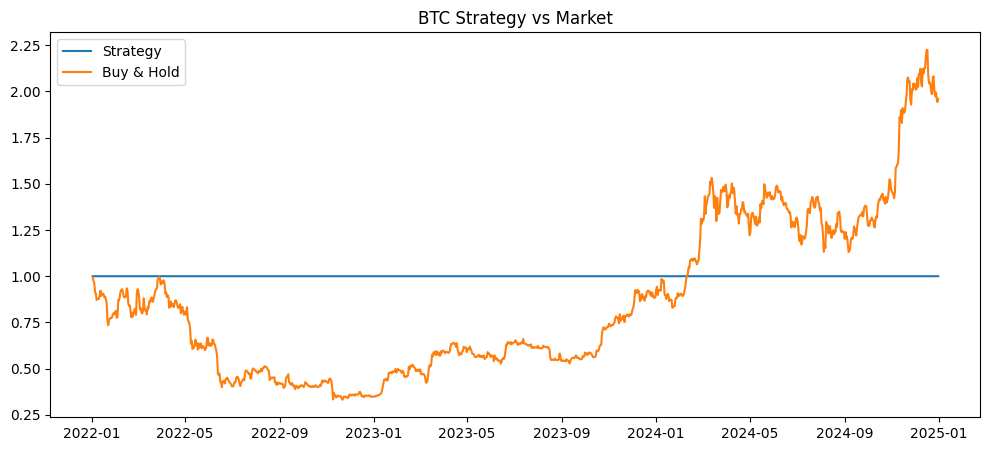

In [59]:
plt.figure(figsize=(12,5))
plt.plot(df['Cumulative_Strategy'], label='Strategy')
plt.plot(df['Cumulative_Market'], label='Buy & Hold')
plt.legend()
plt.title("BTC Strategy vs Market")
plt.show()


In [60]:
sharpe = np.sqrt(252) * df['Strategy_Return'].mean() / df['Strategy_Return'].std()


/tmp/ipython-input-878829694.py:1: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = np.sqrt(252) * df['Strategy_Return'].mean() / df['Strategy_Return'].std()


In [61]:
downside_std = df[df['Strategy_Return'] < 0]['Strategy_Return'].std()
sortino = np.sqrt(252) * df['Strategy_Return'].mean() / downside_std


In [62]:
rolling_max = df['Cumulative_Strategy'].cummax()
drawdown = df['Cumulative_Strategy'] / rolling_max - 1
max_drawdown = drawdown.min()


In [63]:
trades = df['Position'].diff()
winning_trades = df[df['Strategy_Return'] > 0]['Strategy_Return'].count()
losing_trades = df[df['Strategy_Return'] < 0]['Strategy_Return'].count()

total_profit = df[df['Strategy_Return'] > 0]['Strategy_Return'].sum()
total_loss = df[df['Strategy_Return'] < 0]['Strategy_Return'].sum()
net_profit = total_profit + total_loss


In [64]:
print("Sharpe Ratio:", round(sharpe, 2))
print("Sortino Ratio:", round(sortino, 2))
print("Winning Trades:", winning_trades)
print("Losing Trades:", losing_trades)
print("Maximum Drawdown:", round(max_drawdown * 100, 2), "%")
print("Total Profit:", round(total_profit * 100, 2), "%")
print("Net Profit:", round(net_profit * 100, 2), "%")


Sharpe Ratio: nan
Sortino Ratio: nan
Winning Trades: 0
Losing Trades: 0
Maximum Drawdown: 0.0 %
Total Profit: 0.0 %
Net Profit: 0.0 %
